# First thoughts:
<br> There are 4 primary failure sources:<br> 
<b>Circulation pump:</b> drop in forward flow temperature behind the pump <br> 
<b>heatsource:</b> probably full on temperature drop / temperature approaching outside temp across the system <br> 
<b>mixing valves:</b> probably similar symptoms as circulation pump failure, could probably be differenciated with data from the heat source </br>
<b>sensor: </b> probably either NaN or 0 as received signal. <br><br>
So the main indicator for anomalies is an unexpected temperature change with some important side criteria: <br>
forward flow temperatures are dependand on outside temperature. So if outisde temperature is given in the dataset, it would be possible to engineer a feature to account for this dependency.<br>
Additionally temperature drop is expected during evening/nighttime. <br>
domestic hot water on the other hand is neither denpend on time of day nor on outside temperature <br><br>
There are 4 files, named: <br>
system 1 domestic hot water <br>
system 2 forward flow temperature <br>
system 3 forward flow circuit 1 <br>
system 3 forward flow circuit 2 <br> <br>

There are 4 datasets for 3 systems. The first one beeing domestic hot water, the second one beeing forward flow temperature and the third one got data for 2 seperate circuits.<br><br>


As the criteria for anomaly detection differ for domestic hot water and forward flow temperature measurements, with domestic hot water beeing much simpler, it will most likely be appropriate to apporach those seperatly. <br><br>


Due to time constraints and uncertainty of failure criterias for everything apart from circulation pump failure, i will focus on that for the forward flow datasets.<br><br>
Another important question is if two circuits use the same pump? same heat source? same mixing valves? <br>if the two circuits use the same haet source, but seperate pumps, than it is possible to differenciate the failure point by crosschecking data. <br> Let's keep this in mind as an extended goal. 
 




# EDA:

## Imports

In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime 

## Domestic hot water exploration

In [ ]:
df = pd.read_csv("data/system1 domestic hot water.csv", parse_dates=["timestamp"])
df.set_index("timestamp", inplace=True)

df.head()

,avg,min_v,max_v,stddev_v
timestamp,,,,
2025-03-06 16:45:00+00:00,57.7,56.9,58.5,NaN
2025-03-06 02:45:00+00:00,58.2,58.2,58.2,NaN
2025-03-08 09:45:00+00:00,58.8,58.8,58.8,NaN
2025-03-06 17:00:00+00:00,61.2,59.2,62.9,NaN
2025-03-06 05:15:00+00:00,59.0,58.7,59.2,NaN


In [156]:
df.describe()

,avg,min_v,max_v,stddev_v
count,10853.000000,10853.000000,10853.000000,0.0
mean,56.858030,56.252511,57.435281,NaN
std,3.192725,3.634233,3.221714,NaN
min,-2.100000,-8.500000,-2.100000,NaN
25%,56.100000,55.500000,56.400000,NaN
50%,57.200000,56.800000,57.600000,NaN
75%,58.400000,57.900000,58.900000,NaN
max,71.500000,60.900000,85.000000,NaN


In [157]:
df.stddev_v.unique()

array([nan])

In [158]:
df.shape

(10853, 4)

## First Insights:

The column for the standard deviation is empty, which is very unfortunate in regards to anomaly detection. <br>
I could either approximate the standard deviation with the min and max values or drop the column. <br>
I think it is more logical to drop the column and use a the total difference between min and max temperature instead for the purpose of domestic hot water anomaly detection.<br><br>
The timestamps are not in chronological order, that needs to be changed. <br><br>
There are no outside temperatures given, assuming the other files look similar, it makes it more difficult for forward flow temperature anomaly detection, as that variable is a blind spot. <br><br>
Also there seem to be some physically unlikely values (negative temperature values) which might indicate sensor issues. Could be used to differentiate the type of issue apparent.

In [159]:
df = df[['avg', 'min_v', 'max_v', 
    #'stddev_v'
    ]].copy() #dropping the standard deviation column
df.head()

,avg,min_v,max_v
timestamp,,,
2025-03-06 16:45:00+00:00,57.7,56.9,58.5
2025-03-06 02:45:00+00:00,58.2,58.2,58.2
2025-03-08 09:45:00+00:00,58.8,58.8,58.8
2025-03-06 17:00:00+00:00,61.2,59.2,62.9
2025-03-06 05:15:00+00:00,59.0,58.7,59.2


In [160]:
df.index = pd.to_datetime(df.index)
df = df.sort_index() #bringing the timestamp indices in chronological order
df.head()

,avg,min_v,max_v
timestamp,,,
2024-05-01 00:00:00+00:00,58.2,58.2,58.2
2024-05-01 03:45:00+00:00,57.7,57.7,57.7
2024-05-01 04:30:00+00:00,56.1,55.1,57.1
2024-05-01 04:45:00+00:00,57.4,55.6,59.0
2024-05-01 06:00:00+00:00,56.9,56.9,56.9


In [161]:
# Calculate the average time difference between consecutive timestamps
df.index.to_series().diff().value_counts().sort_values(ascending=False)


timestamp
0 days 00:15:00    5324
0 days 00:30:00    1651
0 days 00:45:00     982
0 days 01:00:00     652
0 days 01:15:00     447
0 days 01:30:00     328
0 days 01:45:00     278
0 days 02:00:00     200
0 days 02:15:00     137
0 days 02:30:00     124
0 days 02:45:00     123
0 days 03:00:00      88
0 days 03:15:00      75
0 days 03:45:00      66
0 days 03:30:00      58
0 days 04:15:00      42
0 days 04:00:00      38
0 days 04:45:00      26
0 days 05:15:00      25
0 days 04:30:00      24
0 days 05:00:00      21
0 days 06:00:00      16
0 days 05:45:00      14
0 days 05:30:00      12
0 days 07:30:00      12
0 days 07:15:00      11
0 days 06:15:00      10
0 days 06:45:00       9
0 days 06:30:00       8
0 days 07:00:00       7
0 days 08:15:00       6
0 days 08:30:00       5
0 days 07:45:00       5
0 days 08:45:00       5
0 days 08:00:00       5
0 days 09:00:00       3
0 days 09:45:00       3
0 days 10:30:00       2
0 days 09:30:00       2
0 days 13:15:00       1
0 days 10:00:00       1
0 days

## further insights:
The time passing between the timestamps vary greatly. with 15 minutes beeing the most common. <br>
This may be expected behavior to some extend, but the higher numbers seem odd. <br>
For domestic hot water this is not a major issue as the temperature should stay constant at all times.<br> 
However for forward flow temperature this might become an issue if the measurement interval crosses too far from daytime to nighttime.<br>
The day of time is not important for domestic hot water, but there is the possibility that i want to combine the datasets later on, therefore i will treat the data accordingly. <br>

## Feature Engineering

In [162]:
df['nighttime'] = df.index.time >= datetime.time(22, 0)
df['nighttime'] |= df.index.time < datetime.time(4, 0) 
#arbitary numbers, defining nighttime as between 22:00 and 04:00 might need to revisit this later.
df.head()

,avg,min_v,max_v,nighttime
timestamp,,,,
2024-05-01 00:00:00+00:00,58.2,58.2,58.2,True
2024-05-01 03:45:00+00:00,57.7,57.7,57.7,True
2024-05-01 04:30:00+00:00,56.1,55.1,57.1,False
2024-05-01 04:45:00+00:00,57.4,55.6,59.0,False
2024-05-01 06:00:00+00:00,56.9,56.9,56.9,False


In [163]:
df['time_diff'] = df.index.to_series().diff()
df['time_diff_min'] = df['time_diff'].dt.total_seconds() // 60
df['time_diff_min'] = df['time_diff_min'].astype('Int64') 
df.drop(columns=['time_diff'], inplace=True)
mode_time_diff = df['time_diff_min'].mode()[0]
df['time_diff_min'] = df['time_diff_min'].fillna(mode_time_diff) #filling the missing numbers with the mode value to avoid issues.
#this should only happen for the first row, as the rest of the rows are filled with the time difference between the two timestamps.

In [164]:
df.head()

,avg,min_v,max_v,nighttime,time_diff_min
timestamp,,,,,
2024-05-01 00:00:00+00:00,58.2,58.2,58.2,True,15
2024-05-01 03:45:00+00:00,57.7,57.7,57.7,True,225
2024-05-01 04:30:00+00:00,56.1,55.1,57.1,False,45
2024-05-01 04:45:00+00:00,57.4,55.6,59.0,False,15
2024-05-01 06:00:00+00:00,56.9,56.9,56.9,False,75


In [165]:
df['T_diff'] = df['max_v'] - df['min_v'] #creating a column for temperature difference
df['type'] = 'domestic'
df['ID'] = 'S1'
df.head()

,avg,min_v,max_v,nighttime,time_diff_min,T_diff,type,ID
timestamp,,,,,,,,
2024-05-01 00:00:00+00:00,58.2,58.2,58.2,True,15,0.0,domestic,S1
2024-05-01 03:45:00+00:00,57.7,57.7,57.7,True,225,0.0,domestic,S1
2024-05-01 04:30:00+00:00,56.1,55.1,57.1,False,45,2.0,domestic,S1
2024-05-01 04:45:00+00:00,57.4,55.6,59.0,False,15,3.4,domestic,S1
2024-05-01 06:00:00+00:00,56.9,56.9,56.9,False,75,0.0,domestic,S1


In [166]:
df.describe()

,avg,min_v,max_v,time_diff_min,T_diff
count,10853.000000,10853.000000,10853.000000,10853.0,10853.00000
mean,56.858030,56.252511,57.435281,51.035658,1.18277
std,3.192725,3.634233,3.221714,68.860057,2.59801
min,-2.100000,-8.500000,-2.100000,15.0,0.00000
25%,56.100000,55.500000,56.400000,15.0,0.00000
50%,57.200000,56.800000,57.600000,30.0,0.00000
75%,58.400000,57.900000,58.900000,60.0,1.60000
max,71.500000,60.900000,85.000000,795.0,67.10000


## Quick Visualization

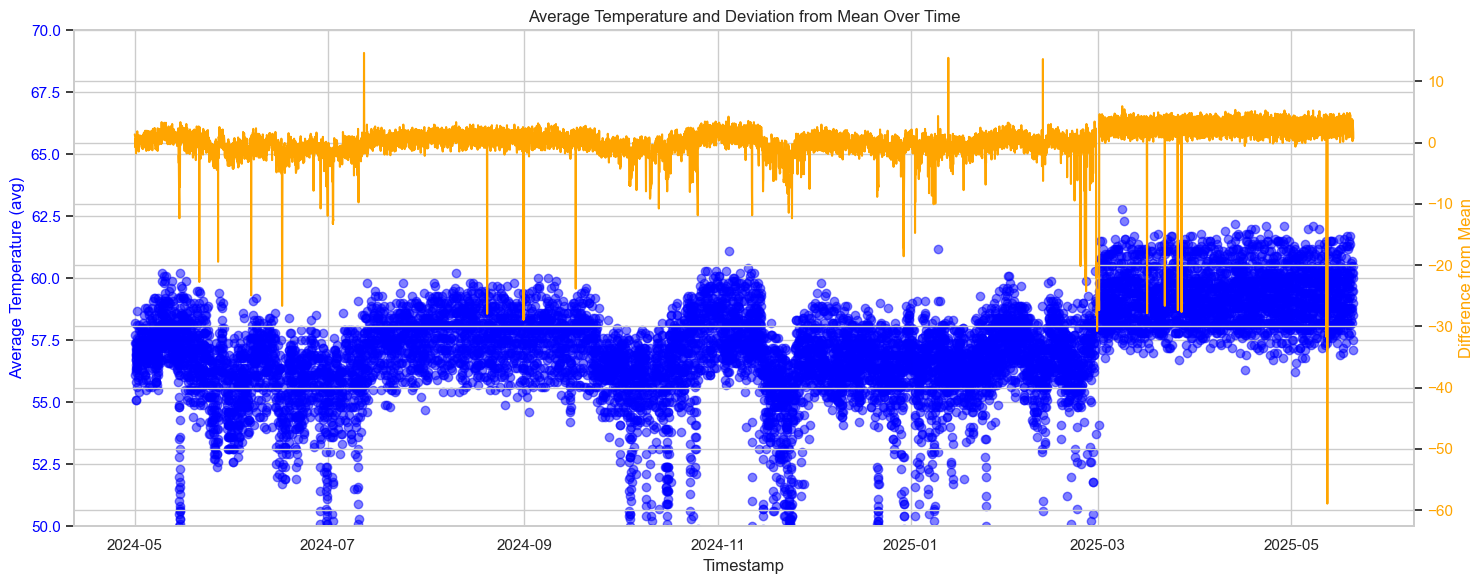

In [167]:
fig, ax1 = plt.subplots(figsize=(15, 6))

# Left y-axis: avg temperature (scatter)
ax1.scatter(df.index, df['avg'], alpha=0.5, color='blue', label='avg')
ax1.set_ylabel('Average Temperature (avg)', color='blue')
ax1.set_ylim(50, 70)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xlabel('Timestamp')

# Right y-axis: difference from mean
avg_mean = df['avg'].mean()
ax2 = ax1.twinx()
ax2.plot(df.index, df['avg'] - avg_mean, color='orange', label='avg - avg_mean')
ax2.set_ylabel('Difference from Mean', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Title and layout
plt.title('Average Temperature and Deviation from Mean Over Time')
fig.tight_layout()
plt.show()

It seems there are timeframes where the average temperature deviates greatly from the norm, also there seem to be times when the temperature fluctuates strongly within a measurement interval, but not showing it in the measure points (presumably because of to big intervals, as seen before).


As a detection mechanism for the domestic hot water it seems to be enough to check for either deviation in the average temperature from the measurement point (and check consecutive measurement points to determine the anomaly period) and to check if there was a deviation in the min and max temperature within an interval (for long intervals > 15 min).

## forward flow temperature

Let's continue with the forward flow temperature dataset and treat it similarly.

In [168]:
df2 = pd.read_csv("system2 forward flow temperature.csv", parse_dates=["timestamp"])
df2.set_index("timestamp", inplace=True)

df2.head()

,avg,min_v,max_v,stddev_v
timestamp,,,,
2025-02-27 05:00:00+00:00,60.8,59.5,62.0,NaN
2025-02-18 20:00:00+00:00,58.1,57.7,58.7,NaN
2025-02-06 11:00:00+00:00,60.5,58.8,62.2,NaN
2025-01-30 03:00:00+00:00,61.5,60.0,63.2,NaN
2025-02-22 11:00:00+00:00,60.5,58.7,62.3,NaN


In [169]:
df2.stddev_v.unique()

array([nan])

the data looks similar and is also missing the standard deviation, as expected.
Feature engineering will be proceeded same as with domestic hot water before.

In [170]:
df2 = df2[['avg', 'min_v', 'max_v', 
    #'stddev_v'
    ]].copy() #dropping the standard deviation column
df2.index = pd.to_datetime(df2.index)
df2 = df2.sort_index() #bringing the timestamp indices in chronological order
df2['nighttime'] = df2.index.time >= datetime.time(22, 0)
df2['nighttime'] |= df2.index.time < datetime.time(4, 0) 
df2['time_diff'] = df2.index.to_series().diff()
df2['time_diff_min'] = df2['time_diff'].dt.total_seconds() // 60
df2['time_diff_min'] = df2['time_diff_min'].astype('Int64') 
df2.drop(columns=['time_diff'], inplace=True)
mode_time_diff = df2['time_diff_min'].mode()[0]
df2['time_diff_min'] = df2['time_diff_min'].fillna(mode_time_diff) #filling the missing numbers with the mode value to avoid issues.
#this should only happen for the first row, as the rest of the rows are filled with the time difference between the two timestamps.
df2['T_diff'] = df2['max_v'] - df2['min_v'] #creating a column for temperature difference
df2['type'] = 'forward'
df2['ID'] = 'S2'
df2.head()


,avg,min_v,max_v,nighttime,time_diff_min,T_diff,type,ID
timestamp,,,,,,,,
2024-10-01 00:00:00+00:00,53.3,52.4,53.9,True,60,1.5,forward,S2
2024-10-01 01:00:00+00:00,53.2,52.4,53.9,True,60,1.5,forward,S2
2024-10-01 02:00:00+00:00,53.4,52.9,53.9,True,60,1.0,forward,S2
2024-10-01 03:00:00+00:00,54.2,53.4,54.9,True,60,1.5,forward,S2
2024-10-01 04:00:00+00:00,54.2,52.9,55.4,False,60,2.5,forward,S2


In [171]:
df2.index.to_series().diff().value_counts().sort_values(ascending=False)

timestamp
0 days 01:00:00    3492
0 days 02:00:00      37
0 days 04:00:00       4
0 days 03:00:00       4
0 days 07:00:00       1
0 days 06:00:00       1
0 days 17:00:00       1
1 days 00:00:00       1
Name: count, dtype: int64

For the forward flow temperature the measurements are much more evenly spaced, with 1 hour beeing the most common.<br>
Measurements that are more than 1 hour apart are probably not wanted or expected.<br>
This could be used as a warning mechanism for defective hardware or software. Due to time constraints I will ignore this for now.

In [172]:
df2.describe()

,avg,min_v,max_v,time_diff_min,T_diff
count,3542.000000,3542.000000,3542.000000,3542.0,3542.000000
mean,55.870920,54.862084,56.853755,61.812535,1.991671
std,7.248844,7.118398,7.452094,30.778121,1.562309
min,11.800000,11.500000,12.000000,60.0,0.000000
25%,51.800000,50.800000,52.500000,60.0,1.000000
50%,58.100000,57.300000,58.800000,60.0,1.500000
75%,60.900000,59.600000,62.400000,60.0,2.600000
max,67.800000,67.300000,68.900000,1440.0,22.800000


As expected the standard deviation is higher than for domestic hot water due to denpendency on outside temperature and day/night cycles.

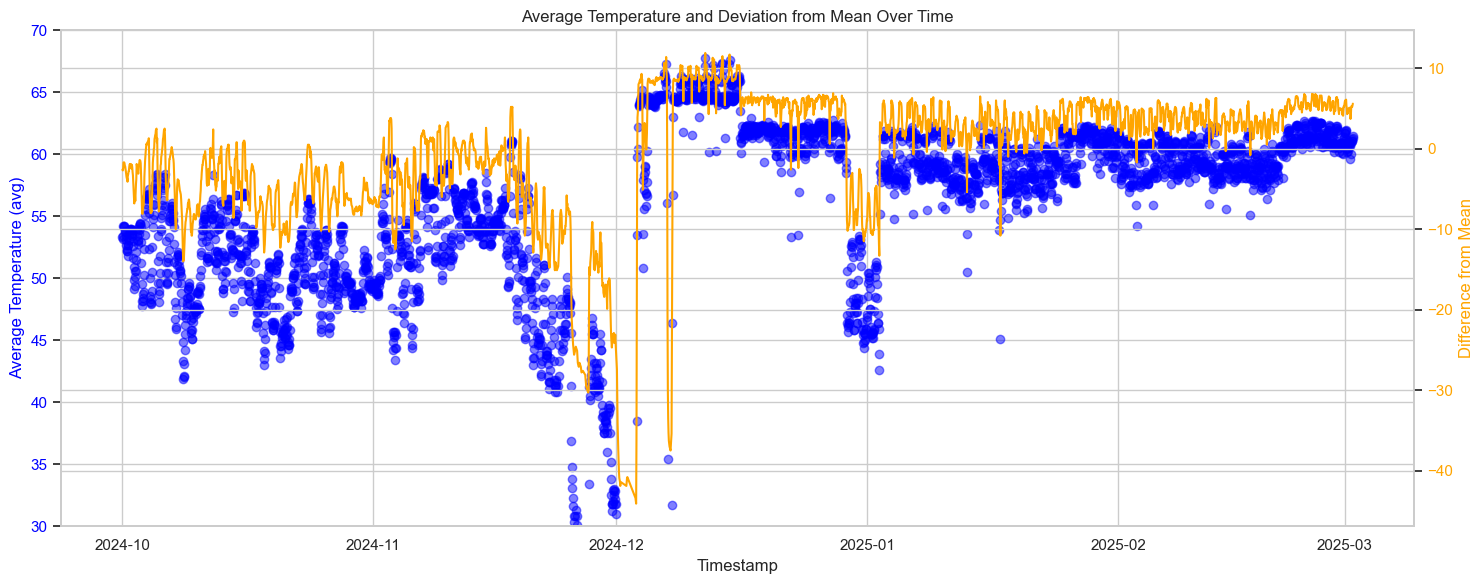

In [173]:
fig, ax1 = plt.subplots(figsize=(15, 6))

# Left y-axis: avg temperature (scatter)
ax1.scatter(df2.index, df2['avg'], alpha=0.5, color='blue', label='avg')
ax1.set_ylabel('Average Temperature (avg)', color='blue')
ax1.set_ylim(30, 70)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xlabel('Timestamp')

# Right y-axis: difference from mean
avg_mean = df2['avg'].mean()
ax2 = ax1.twinx()
ax2.plot(df2.index, df2['avg'] - avg_mean, color='orange', label='avg - avg_mean')
ax2.set_ylabel('Difference from Mean', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Title and layout
plt.title('Average Temperature and Deviation from Mean Over Time')
fig.tight_layout()
plt.show()

It seems that an issue occured in december which got worse over a longer period of time. <br>
lets check how it diffentiates if we only use daytime data.

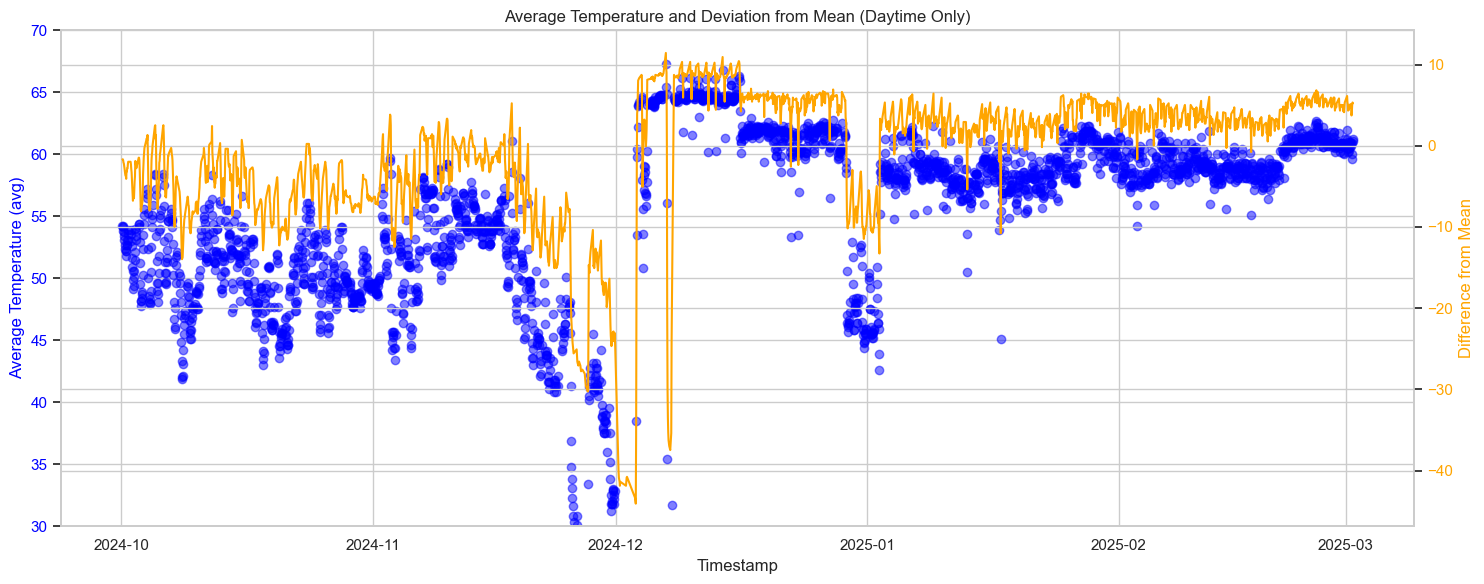

In [174]:
df_day = df2[df2['nighttime'] == False]
fig, ax1 = plt.subplots(figsize=(15, 6))

# Left y-axis: avg temperature (scatter)
ax1.scatter(df_day.index, df_day['avg'], alpha=0.5, color='blue', label='avg')
ax1.set_ylabel('Average Temperature (avg)', color='blue')
ax1.set_ylim(30, 70)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xlabel('Timestamp')

# Right y-axis: difference from mean (calculated using full data)
avg_mean = df2['avg'].mean()
ax2 = ax1.twinx()
ax2.plot(df_day.index, df_day['avg'] - avg_mean, color='orange', label='avg - avg_mean')
ax2.set_ylabel('Difference from Mean', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Title and layout
plt.title('Average Temperature and Deviation from Mean (Daytime Only)')
fig.tight_layout()
plt.show()

In [175]:
df_day.describe()

,avg,min_v,max_v,time_diff_min,T_diff
count,2664.000000,2664.000000,2664.000000,2664.0,2664.000000
mean,55.208634,54.245571,56.144632,62.162162,1.899062
std,7.534096,7.454307,7.697772,35.199906,1.656187
min,11.800000,11.500000,12.000000,60.0,0.000000
25%,51.000000,50.000000,51.800000,60.0,1.000000
50%,57.800000,57.000000,58.400000,60.0,1.500000
75%,60.400000,59.200000,61.600000,60.0,2.500000
max,67.300000,65.800000,68.900000,1440.0,22.800000


In [176]:
df_night = df2[df2['nighttime'] == True]
df_night.describe()

,avg,min_v,max_v,time_diff_min,T_diff
count,878.000000,878.000000,878.000000,878.0,878.000000
mean,57.880410,56.732688,59.005353,60.751708,2.272665
std,5.867379,5.586389,6.175204,7.810751,1.192070
min,24.500000,23.000000,26.000000,60.0,0.000000
25%,54.200000,53.400000,54.900000,60.0,1.500000
50%,60.100000,59.000000,61.400000,60.0,2.500000
75%,61.800000,60.300000,63.200000,60.0,3.100000
max,67.800000,67.300000,68.900000,180.0,10.500000


the standard deviation increases slightly, probably as expected, as the water is not circulating during the nighttime.


## combining dataframes

For further use I want to create a single dataset, which will than be used for the detection algorithm. Therefore i will change the other datasets the same way as the previous one and combine them.

In [177]:
df3 = pd.read_csv("system3 forward flow circuit1.csv", parse_dates=["timestamp"])
df3.set_index("timestamp", inplace=True)
df3 = df3[['avg', 'min_v', 'max_v', 
    #'stddev_v'
    ]].copy() #dropping the standard deviation column
df3.index = pd.to_datetime(df3.index)
df3 = df3.sort_index() #bringing the timestamp indices in chronological order
df3['nighttime'] = df3.index.time >= datetime.time(22, 0)
df3['nighttime'] |= df3.index.time < datetime.time(4, 0) 
df3['time_diff'] = df3.index.to_series().diff()
df3['time_diff_min'] = df3['time_diff'].dt.total_seconds() // 60
df3['time_diff_min'] = df3['time_diff_min'].astype('Int64') 
df3.drop(columns=['time_diff'], inplace=True)
mode_time_diff = df3['time_diff_min'].mode()[0]
df3['time_diff_min'] = df3['time_diff_min'].fillna(mode_time_diff) #filling the missing numbers with the mode value to avoid issues.
#this should only happen for the first row, as the rest of the rows are filled with the time difference between the two timestamps.
df3['T_diff'] = df3['max_v'] - df3['min_v'] #creating a column for temperature difference
df3['type'] = 'forward'
df3['ID'] = 'S3C1'
df3.head()

,avg,min_v,max_v,nighttime,time_diff_min,T_diff,type,ID
timestamp,,,,,,,,
2022-12-07 01:15:00+00:00,65.2,63.5,66.7,True,15,3.2,forward,S3C1
2022-12-07 01:30:00+00:00,64.7,62.5,66.8,True,15,4.3,forward,S3C1
2022-12-07 01:45:00+00:00,64.3,62.5,66.6,True,15,4.1,forward,S3C1
2022-12-07 02:00:00+00:00,64.4,62.6,66.2,True,15,3.6,forward,S3C1
2022-12-07 02:15:00+00:00,64.1,62.3,66.5,True,15,4.2,forward,S3C1


In [178]:
df4 = pd.read_csv("system3 forward flow circuit2.csv", parse_dates=["timestamp"])
df4.set_index("timestamp", inplace=True)
df4 = df4[['avg', 'min_v', 'max_v', 
    #'stddev_v'
    ]].copy() #dropping the standard deviation column
df4.index = pd.to_datetime(df4.index)
df4 = df4.sort_index() #bringing the timestamp indices in chronological order
df4['nighttime'] = df4.index.time >= datetime.time(22, 0)
df4['nighttime'] |= df4.index.time < datetime.time(4, 0) 
df4['time_diff'] = df4.index.to_series().diff()
df4['time_diff_min'] = df4['time_diff'].dt.total_seconds() // 60
df4['time_diff_min'] = df4['time_diff_min'].astype('Int64') 
df4.drop(columns=['time_diff'], inplace=True)
mode_time_diff = df4['time_diff_min'].mode()[0]
df4['time_diff_min'] = df4['time_diff_min'].fillna(mode_time_diff) #filling the missing numbers with the mode value to avoid issues.
#this should only happen for the first row, as the rest of the rows are filled with the time difference between the two timestamps.
df4['T_diff'] = df4['max_v'] - df4['min_v'] #creating a column for temperature difference
df4['type'] = 'forward'
df4['ID'] = 'S3C1'
df4.head()

,avg,min_v,max_v,nighttime,time_diff_min,T_diff,type,ID
timestamp,,,,,,,,
2022-12-07 01:15:00+00:00,65.7,64.1,67.2,True,15,3.1,forward,S3C1
2022-12-07 01:30:00+00:00,65.3,63.1,67.2,True,15,4.1,forward,S3C1
2022-12-07 01:45:00+00:00,64.9,63.1,67.2,True,15,4.1,forward,S3C1
2022-12-07 02:00:00+00:00,65.0,63.1,66.8,True,15,3.7,forward,S3C1
2022-12-07 02:15:00+00:00,64.8,62.9,67.1,True,15,4.2,forward,S3C1


In [179]:
dffinal = pd.concat([df, df2, df3, df4]).sort_index().reset_index()

In [180]:
dffinal.head()

,timestamp,avg,min_v,max_v,nighttime,time_diff_min,T_diff,type,ID
0,2022-12-07 01:15:00+00:00,65.7,64.1,67.2,True,15,3.1,forward,S3C1
1,2022-12-07 01:15:00+00:00,65.2,63.5,66.7,True,15,3.2,forward,S3C1
2,2022-12-07 01:30:00+00:00,64.7,62.5,66.8,True,15,4.3,forward,S3C1
3,2022-12-07 01:30:00+00:00,65.3,63.1,67.2,True,15,4.1,forward,S3C1
4,2022-12-07 01:45:00+00:00,64.3,62.5,66.6,True,15,4.1,forward,S3C1


In [181]:
dffinal.to_csv("combined_data.csv", index=False)